In [4]:
%load_ext autoreload
%autoreload 1

In [6]:
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize()
import multiprocessing
import numpy as np
import os
from collections import Counter, defaultdict
import itertools
import sys 
sys.path.append("../..") 

%aimport preprocessing
%aimport utils
%aimport p2v

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from utils import prinT
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns = None
pd.set_option('max_colwidth', None)

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [7]:
k_list = [8, 8, 13, 25, 19, 18, 23]
start_year_list = ['1950', '1960', '1970', '1980', '1990', '2000', '2010']
end_year_list = ['1959', '1969', '1979', '1989', '1999', '2009', '2021']
ref_start_year = 2010
ref_end_year = 2021

# Functions for processing time series

In [8]:
def filter_nan_in_middle(x):
    val_list = x.to_list()
    
    start_idx = -1
    end_idx = -1
    nan_in_middle = False
    for i in range(0, len(val_list)):
        if not np.isnan(val_list[i]):
            start_idx = i
            break
    for i in range(len(val_list)-1, -1, -1):
        if not np.isnan(val_list[i]):
            end_idx = i
            break
    for i in range(start_idx, end_idx):
        if np.isnan(val_list[i]):
            nan_in_middle = True
            break
    if start_idx == end_idx:
        len_of_1 = True
    else :
        len_of_1 = False
    return nan_in_middle, len_of_1, start_idx, end_idx

# Generate a dataframe which contains periodical's local semantic change

In [9]:
def cal_local_distance(x, tar_neighbor_idxs, ref_neighbor_idxs, tar_vectors, ref_vectors):
    neighbor_idx_list = list(set(tar_neighbor_idxs[x]).union(set(ref_neighbor_idxs[x])))
    tar_neighbor_vectors = [tar_vectors[idx] for idx in neighbor_idx_list]
    ref_neighbor_vectors = [ref_vectors[idx] for idx in neighbor_idx_list]
    tar_focal_vector = tar_vectors[x]
    ref_focal_vector = ref_vectors[x]

    tar_second_order_change = cosine_similarity(tar_focal_vector.reshape(1,-1), tar_neighbor_vectors)
    ref_second_order_change = cosine_similarity(ref_focal_vector.reshape(1,-1), ref_neighbor_vectors)

    return paired_distances(tar_second_order_change, ref_second_order_change, metric='cosine')[0]

In [10]:
from sklearn.metrics.pairwise import cosine_similarity, paired_distances

model = p2v.P2V()

local_semantic_change_df = pd.DataFrame(columns=['VID'])
col_name_list = ['semantic_change_1960s', 
                 'semantic_change_1970s', 
                 'semantic_change_1980s',
                 'semantic_change_1990s',
                 'semantic_change_2000s',
                 'semantic_change_2010s']

for i in range(0, 6):
    old_start_year, old_end_year = start_year_list[i], end_year_list[i]
    new_start_year, new_end_year = start_year_list[i+1], end_year_list[i+1]
    print("-----------------------")
    prinT("start comparing {}-{} with the {}-{}".format(old_start_year, old_end_year, new_start_year, new_end_year))

    old_wv = model.load_wv(old_start_year, old_end_year, 100, 10)
    new_wv = model.load_wv(new_start_year, new_end_year, 100, 10)
    
    old_VIDs = old_wv.index_to_key
    new_VIDs = new_wv.index_to_key
    shared_VIDs = list(set(old_VIDs) & set(new_VIDs))
    prinT("the number of shared VIDs between this two decades: %d" %len(shared_VIDs))
    
    old_idx = [old_wv.get_index(VID) for VID in shared_VIDs]
    new_idx = [new_wv.get_index(VID) for VID in shared_VIDs]
    
    old_vectors = old_wv.get_normed_vectors()[old_idx]
    new_vectors = new_wv.get_normed_vectors()[new_idx]

    prinT("finish, start generate neighbor union...")
    new_neighbor_idxs = np.argsort(cosine_similarity(new_vectors, new_vectors))[:, -2:-k_list[i]-2:-1]
    old_neighbor_idxs = np.argsort(cosine_similarity(old_vectors, old_vectors))[:, -2:-k_list[-1]-2:-1]
    
    prinT("start cal local neighbor distance...")
    dist_df = pd.DataFrame({'VID': shared_VIDs})
    dist = dist_df.index.to_series().parallel_apply(cal_local_distance, args=(old_neighbor_idxs, 
                                                                              new_neighbor_idxs, 
                                                                              old_vectors, 
                                                                              new_vectors))
    prinT("finish")

    dist_df[col_name_list[i]] = dist
    local_semantic_change_df = local_semantic_change_df.merge(dist_df, on='VID', how='outer')
    local_semantic_change_df['total_semantic_change_'+new_start_year+'s'] = local_semantic_change_df[col_name_list[0:i+1]].sum(axis=1)

2024-01-19 15:56:12 -- start loading Mag_venue_info_df
2024-01-19 15:56:12 -- finish.
2024-01-19 15:56:12 -- start loading labeled_journal_info_df
2024-01-19 15:56:12 -- finish.
-----------------------
2024-01-19 15:56:12 -- start comparing 1950-1959 with the 1960-1969
2024-01-19 15:56:12 -- start loading word vectors...
2024-01-19 15:56:12 -- word vectors loaded, and its shape is: (1645, 100)
2024-01-19 15:56:12 -- start loading word vectors...
2024-01-19 15:56:12 -- word vectors loaded, and its shape is: (3116, 100)
2024-01-19 15:56:12 -- the number of shared VIDs between this two decades: 1500
2024-01-19 15:56:12 -- finish, start generate neighbor union...
2024-01-19 15:56:13 -- start cal local neighbor distance...
2024-01-19 15:56:13 -- finish
-----------------------
2024-01-19 15:56:13 -- start comparing 1960-1969 with the 1970-1979
2024-01-19 15:56:13 -- start loading word vectors...
2024-01-19 15:56:13 -- word vectors loaded, and its shape is: (3116, 100)
2024-01-19 15:56:13 -- 

In [11]:
# Labelling
local_semantic_change_df.loc[:,'venue_name'] = local_semantic_change_df['VID'].apply(lambda x: model.MAG_venue_info_df.at[x, 'OriginalVenue'])
# Using the lastes decade's labels
VID_labele_dict = model.load_VID_labeled(2010, 2021, 100, 10)
local_semantic_change_df['scopus_label'] = local_semantic_change_df.VID.map(lambda x: VID_labele_dict['label'][VID_labele_dict['VID'].index(x)] if x in VID_labele_dict['VID']
                                                                            else np.nan)

2024-01-19 15:57:41 -- start loading VID_labeled...
2024-01-19 15:57:41 -- finish.


In [12]:
# incorrect venues in MAG
corrupted_venue_name_list = ['Japanese Journal of Pharmacology', 
                             'Journal of Computers',
                             'Journal of Algorithms',
                             'Journal of Agricultural Engineering Research',
                             'Sozial-und Praventivmedizin',
                             'Scientia Forestalis',
                             'Interpretation',
                             'Genes',
                             'Protein Science',
                             'Hospital Medicine',
                             'Immunotechnology',
                             'Journal of Ayurveda and Integrative Medicine',
                             'Versus',
                             'Tradition',
                             'ACM Transactions on Cyber-Physical Systems',
                             'Journal of Biomedical Engineering',
                             'Antibiotics and Chemotherapy',
                             'Social Work',
                             'Production Journal',
                             'Insight',
                             'Sats',
                             'English',
                             'Leonardo',
                             'The Forum',
                             'Chemical Industry',
                             'The American review of respiratory disease',
                             'Chemistry & Industry',
                            ]

In [13]:
# Filtering
local_semantic_change_df = local_semantic_change_df[~(local_semantic_change_df.venue_name.isin(corrupted_venue_name_list))]
local_semantic_change_df[['nan_in_middle', 
                          'len_of_1', 
                          'start_idx', 
                          'end_idx']] = local_semantic_change_df[col_name_list].apply(filter_nan_in_middle, axis=1, result_type='expand')
# Make sure that each time series never interrupts and has a value for the lastest decade
local_semantic_change_df = local_semantic_change_df[(local_semantic_change_df.nan_in_middle==False) & (local_semantic_change_df.end_idx==5)]

In [14]:
local_semantic_change_df

,VID,semantic_change_1960s,total_semantic_change_1960s,semantic_change_1970s,total_semantic_change_1970s,semantic_change_1980s,total_semantic_change_1980s,semantic_change_1990s,total_semantic_change_1990s,semantic_change_2000s,total_semantic_change_2000s,semantic_change_2010s,total_semantic_change_2010s,venue_name,scopus_label,nan_in_middle,len_of_1,start_idx,end_idx
0,2.785285e+06,0.019514,0.019514,0.012496,0.032010,0.010597,0.042607,0.005943,0.048550,0.002106,0.050656,0.004989,0.055645,The Journal of Comparative Neurology,Neuroscience,False,False,0,5
2,2.756444e+09,0.022656,0.022656,0.025409,0.048065,0.014738,0.062802,0.023930,0.086732,0.042106,0.128838,0.123090,0.251928,Advances in internal medicine,NaN,False,False,0,5
3,1.709670e+08,0.034859,0.034859,0.035788,0.070647,0.022828,0.093475,0.018376,0.111850,0.012381,0.124232,0.008327,0.132559,American Journal of Epidemiology,Medicine,False,False,0,5
4,1.241662e+08,0.008383,0.008383,0.009423,0.017806,0.009184,0.026990,0.010620,0.037609,0.015446,0.053055,0.008831,0.061886,Quarterly Journal of Mechanics and Applied Mathematics,Mathematics,False,False,0,5
5,2.764775e+09,0.003786,0.003786,0.004354,0.008140,0.007919,0.016058,0.005507,0.021565,0.004847,0.026412,0.003399,0.029811,Journal of the Geological Society of Japan,Earth and Planetary Sciences,False,False,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27043,2.764439e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005091,0.005091,Bulgarian Journal of Veterinary Medicine,Veterinary,False,True,5,5
27044,2.898526e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010614,0.010614,EMC - AKOS - Trattato di Medicina,NaN,False,True,5,5
27045,2.010644e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004490,0.004490,European Journal of Preventive Cardiology,Medicine,False,True,5,5
27046,1.125908e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016692,0.016692,Journal of Transport and Land Use,Social Sciences,False,True,5,5


# Plot single periodical's local semantic change in every decade

In [15]:
journal_abbr_dict = {'Nature': 'Nature',
             'Proceedings of The Royal Society B: Biological Sciences': 'Proc. R. Soc. B',
             'Quarterly Journal of Economics': 'QJE', 
             'Cognitive Science': 'Cogn Sci.',
             'The Imaging Science Journal': 'Imaging Sci. J.',
              }

<Figure size 1920x1440 with 0 Axes>

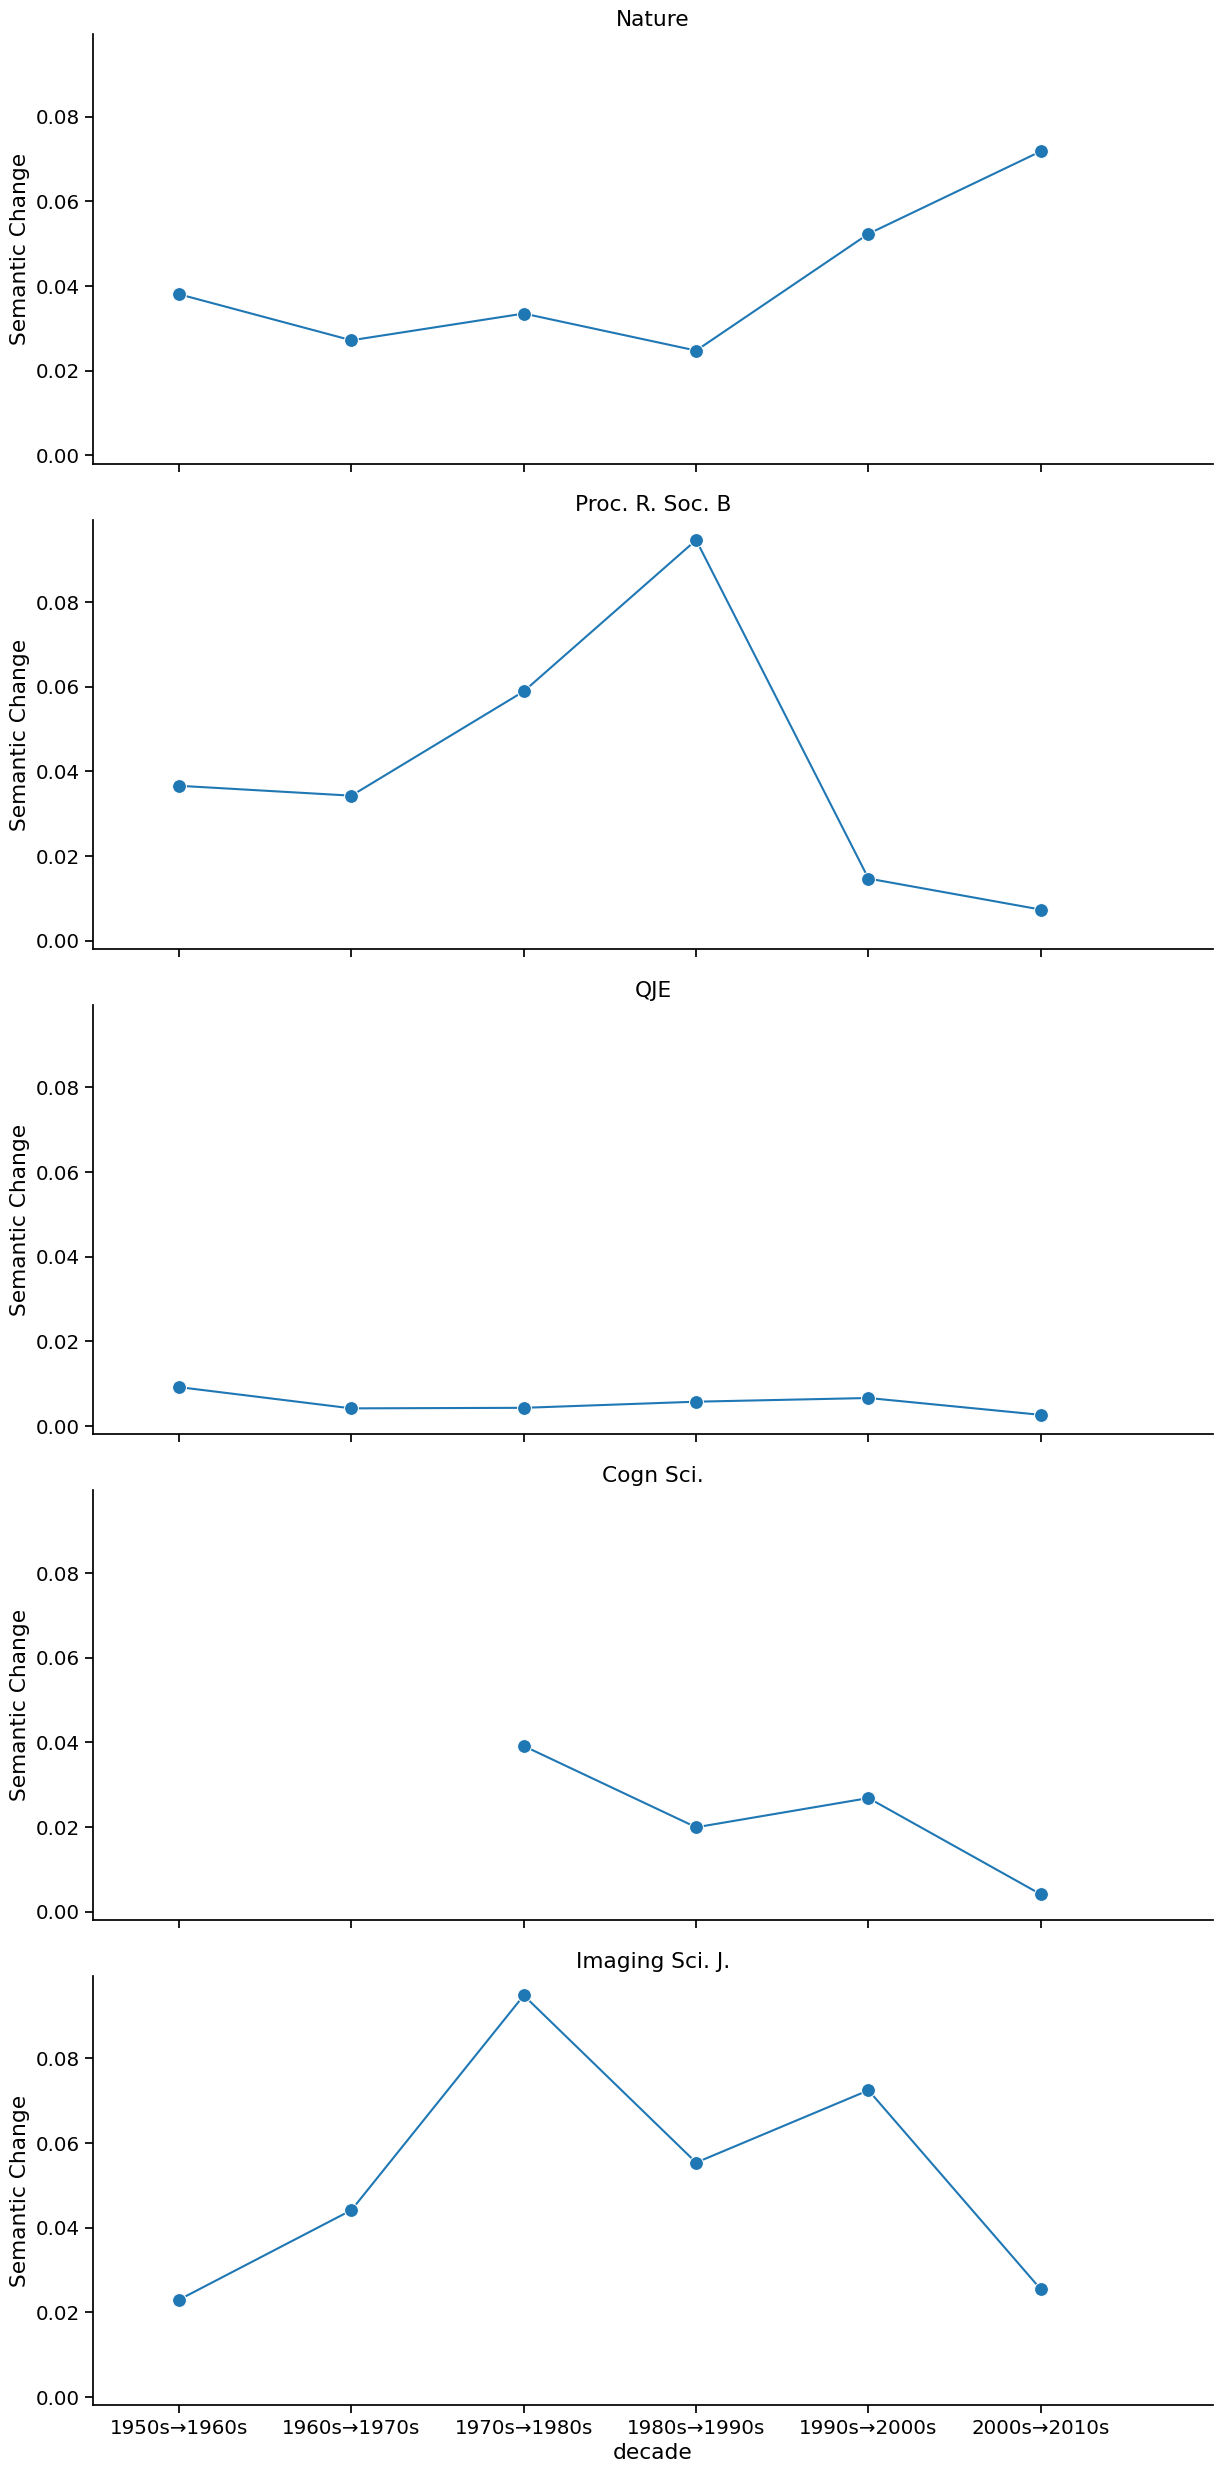

In [16]:
local_semantic_change_df_rename = local_semantic_change_df[local_semantic_change_df.venue_name.isin(journal_abbr_dict.keys())].copy()
local_semantic_change_df_rename.venue_name = local_semantic_change_df_rename.venue_name.replace(journal_abbr_dict)
local_semantic_change_df_rename = local_semantic_change_df_rename[['semantic_change_1960s',
                                                                   'semantic_change_1970s', 
                                                                   'semantic_change_1980s',
                                                                   'semantic_change_1990s',
                                                                   'semantic_change_2000s',
                                                                   'semantic_change_2010s',
                                                                   'venue_name']].rename(columns={'semantic_change_1960s':'semantic_change_1950s→1960s',
                                                                                                  'semantic_change_1970s':'semantic_change_1960s→1970s', 
                                                                                                  'semantic_change_1980s':'semantic_change_1970s→1980s', 
                                                                                                  'semantic_change_1990s':'semantic_change_1980s→1990s', 
                                                                                                  'semantic_change_2000s':'semantic_change_1990s→2000s', 
                                                                                                  'semantic_change_2010s':'semantic_change_2000s→2010s', 
                                                                                                 })
local_semantic_change_df_wide = pd.wide_to_long(local_semantic_change_df_rename,
                                                stubnames=['semantic_change'],
                                                suffix='.+',
                                                sep='_',
                                                i = ['venue_name'],
                                                j = 'decade')

plt.figure(dpi=300)
with sns.plotting_context("notebook", font_scale=1.3):
    g1 = sns.relplot(data=local_semantic_change_df_wide,
                    x='decade', y='semantic_change',
                    legend=False,
                    row='venue_name', row_order=abbr_dict.values(), aspect=2.5, facet_kws={'xlim':(-0.5,6)},
                    kind='line', marker='o', markersize=10)
    g1.tick_params(axis='both', bottom='on',left='on')

    g1.set_titles("{row_name}")
    g1.set_ylabels('Semantic Change')

In [17]:
g1.savefig('single_periodical_local_semantic_change.pdf', 
          dpi = 300, 
          facecolor='white', 
          transparent=False, 
          bbox_inches='tight')

# Plot the distribution of periodicals' total semantic change 

In [18]:
journal_abbr_dict = {# 1950s
             'CA: A Cancer Journal for Clinicians':'CA: Cancer J. Clin.',
             'Quarterly Journal of Economics': 'QJE', 
             'Econometrica': 'Econometrica', 
             'Psychological Bulletin': 'Psychol. Bull.',
             'Chemical Reviews': 'Chem. Rev.',
             'JAMA': 'JAMA',
             'Science': 'Science',
             'Nature': 'Nature',
             'Proceedings of the National Academy of Sciences of the United States of America': 'PNAS',
             'Physical Review Letters': 'PRL',
             'The New England Journal of Medicine': 'NEJM',
             'American Sociological Review': 'ASR',
             'Annals of Mathematics':'Ann. Math.',
             'The Lancet': 'Lancet',
             'BMJ': 'BMJ',
             'Proceedings of The Royal Society B: Biological Sciences': 'Proc. R. Soc. B',
    
             # 1960s
             'Atmosphere':'Atmosphere',
             'Language Learning': 'Lang. Learn.',
             'Automatica': 'Automatica',
             'Carbon':'Carbon',
             'Stanford Law Review': 'SLR',
             'Computing': 'Computing',
             'Journal of Applied Crystallography': 'J. Appl. Crystallogr.',
             'Ultrasonics': 'Ultrasonics',
             'IEEE Transactions on Nuclear Science': 'IEEE Trans Nucl Sci',
             'IEEE Transactions on Biomedical Engineering': 'IEEE. Trans. Biomed. Eng.',
             'Pattern Recognition': 'Pattern Recognit.',
             'Physics Letters B': 'PLB',
             'Journal of Financial and Quantitative Analysis': 'JFQA',
                
             # 1970s
             'Studies in Second Language Acquisition':'Stud. Second Lang. Acquis.',
             'Linguistic Inquiry': 'Linguist. Inq.',
             'European Journal of Political Research': 'EJPR',
             'Accounting Organizations and Society': 'Account. Organ. Soc.',
             'Clinical Infectious Diseases': 'Clin. Infect. Dis.',
             'Economic Analysis and Policy': 'Econ Anal Policy',
             'Research Policy': 'Res. Policy',
             'Gene': 'Gene',
             'Pain': 'Pain',
             'Social Networks': 'Soc. Netw.',
             'Life sciences in space research': 'Life Sci Space Res',
             'Computational Biology and Chemistry': 'Comput Biol Chem',
             'Civil Engineering': 'C.E.J',
             'Journal of Biosciences': 'J. Biosci.',
             'Cell': 'Cell',
    
             # 1980s
             'Applied Linguistics':'Appl. Linguist.',
             'Journal of Accounting and Economics': 'J. Account. Econ.',
             'Journal of Accounting and Public Policy': 'JAPP',
             'Journal of Physics: Condensed Matter': 'J. Phys. Condens. Matter',
             'Transport Reviews': 'Transp. Rev.',
             'European Management Journal': 'EMJ',
             'International Journal of Remote Sensing': 'Int. J. Remote Sens.',
             'Stem Cells': 'Stem Cells',
             'Journal of Chemometrics': 'J. Chemom.',
             'Bioelectromagnetics': 'Bioelectromagnetics',
             'neural information processing systems': 'NeurIPS',
             'IEEE Transactions on Medical Imaging': 'IEEE TMI',

             # 1990s
             'The Accounting Review': 'Account. Rev.',
             'Human Resource Management Journal': 'Hum. Resour. Manag. J.',
             'Cancer Cell': 'Cancer Cell',
             'IEEE Transactions on Applied Superconductivity': 'IEEE TAS',
             'Cell Research': 'Cell Res.',
             'the web conference': 'TheWebConf',
             'knowledge discovery and data mining': 'KDD',
             'empirical methods in natural language processing': 'EMNLP',
             'Materials': 'Materials',
             'Sensors': 'Sensor',
             'Complexity': 'Complexity',

             # 2000s
             'PLOS ONE': 'PLOS ONE',
             'Nature Reviews Immunology': 'Nat. Rev. Immunol.',
             'Nature Materials': 'Nat. Mater',
             'Lancet Oncology': 'Lancet Oncol.',
             'Nature Photonics': 'Nat. Photonics',
             'Obesity': 'Obesity',
             'Nature Chemical Biology': 'Nat. Chem. Biol.',
             'IEEE Transactions on Industrial Informatics': 'IEEE TII',
             'BMC Research Notes': 'BMC Res. Notes',
            }

display(local_semantic_change_df[(local_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(local_semantic_change_df.start_idx==0)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))
display(local_semantic_change_df[(local_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(local_semantic_change_df.start_idx==1)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))
display(local_semantic_change_df[(local_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(local_semantic_change_df.start_idx==2)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))
display(local_semantic_change_df[(local_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(local_semantic_change_df.start_idx==3)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))
display(local_semantic_change_df[(local_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(local_semantic_change_df.start_idx==4)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))
display(local_semantic_change_df[(local_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(local_semantic_change_df.start_idx==5)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))

,venue_name,total_semantic_change_2010s
712,The Imaging Science Journal,0.315188
85,Nature,0.247474
1091,Proceedings of The Royal Society B: Biological Sciences,0.246380
374,Quarterly Journal of Economics,0.032855


,venue_name,total_semantic_change_2010s


,venue_name,total_semantic_change_2010s
5000,Cognitive Science,0.089902


,venue_name,total_semantic_change_2010s


,venue_name,total_semantic_change_2010s


,venue_name,total_semantic_change_2010s


<Figure size 1920x1440 with 0 Axes>

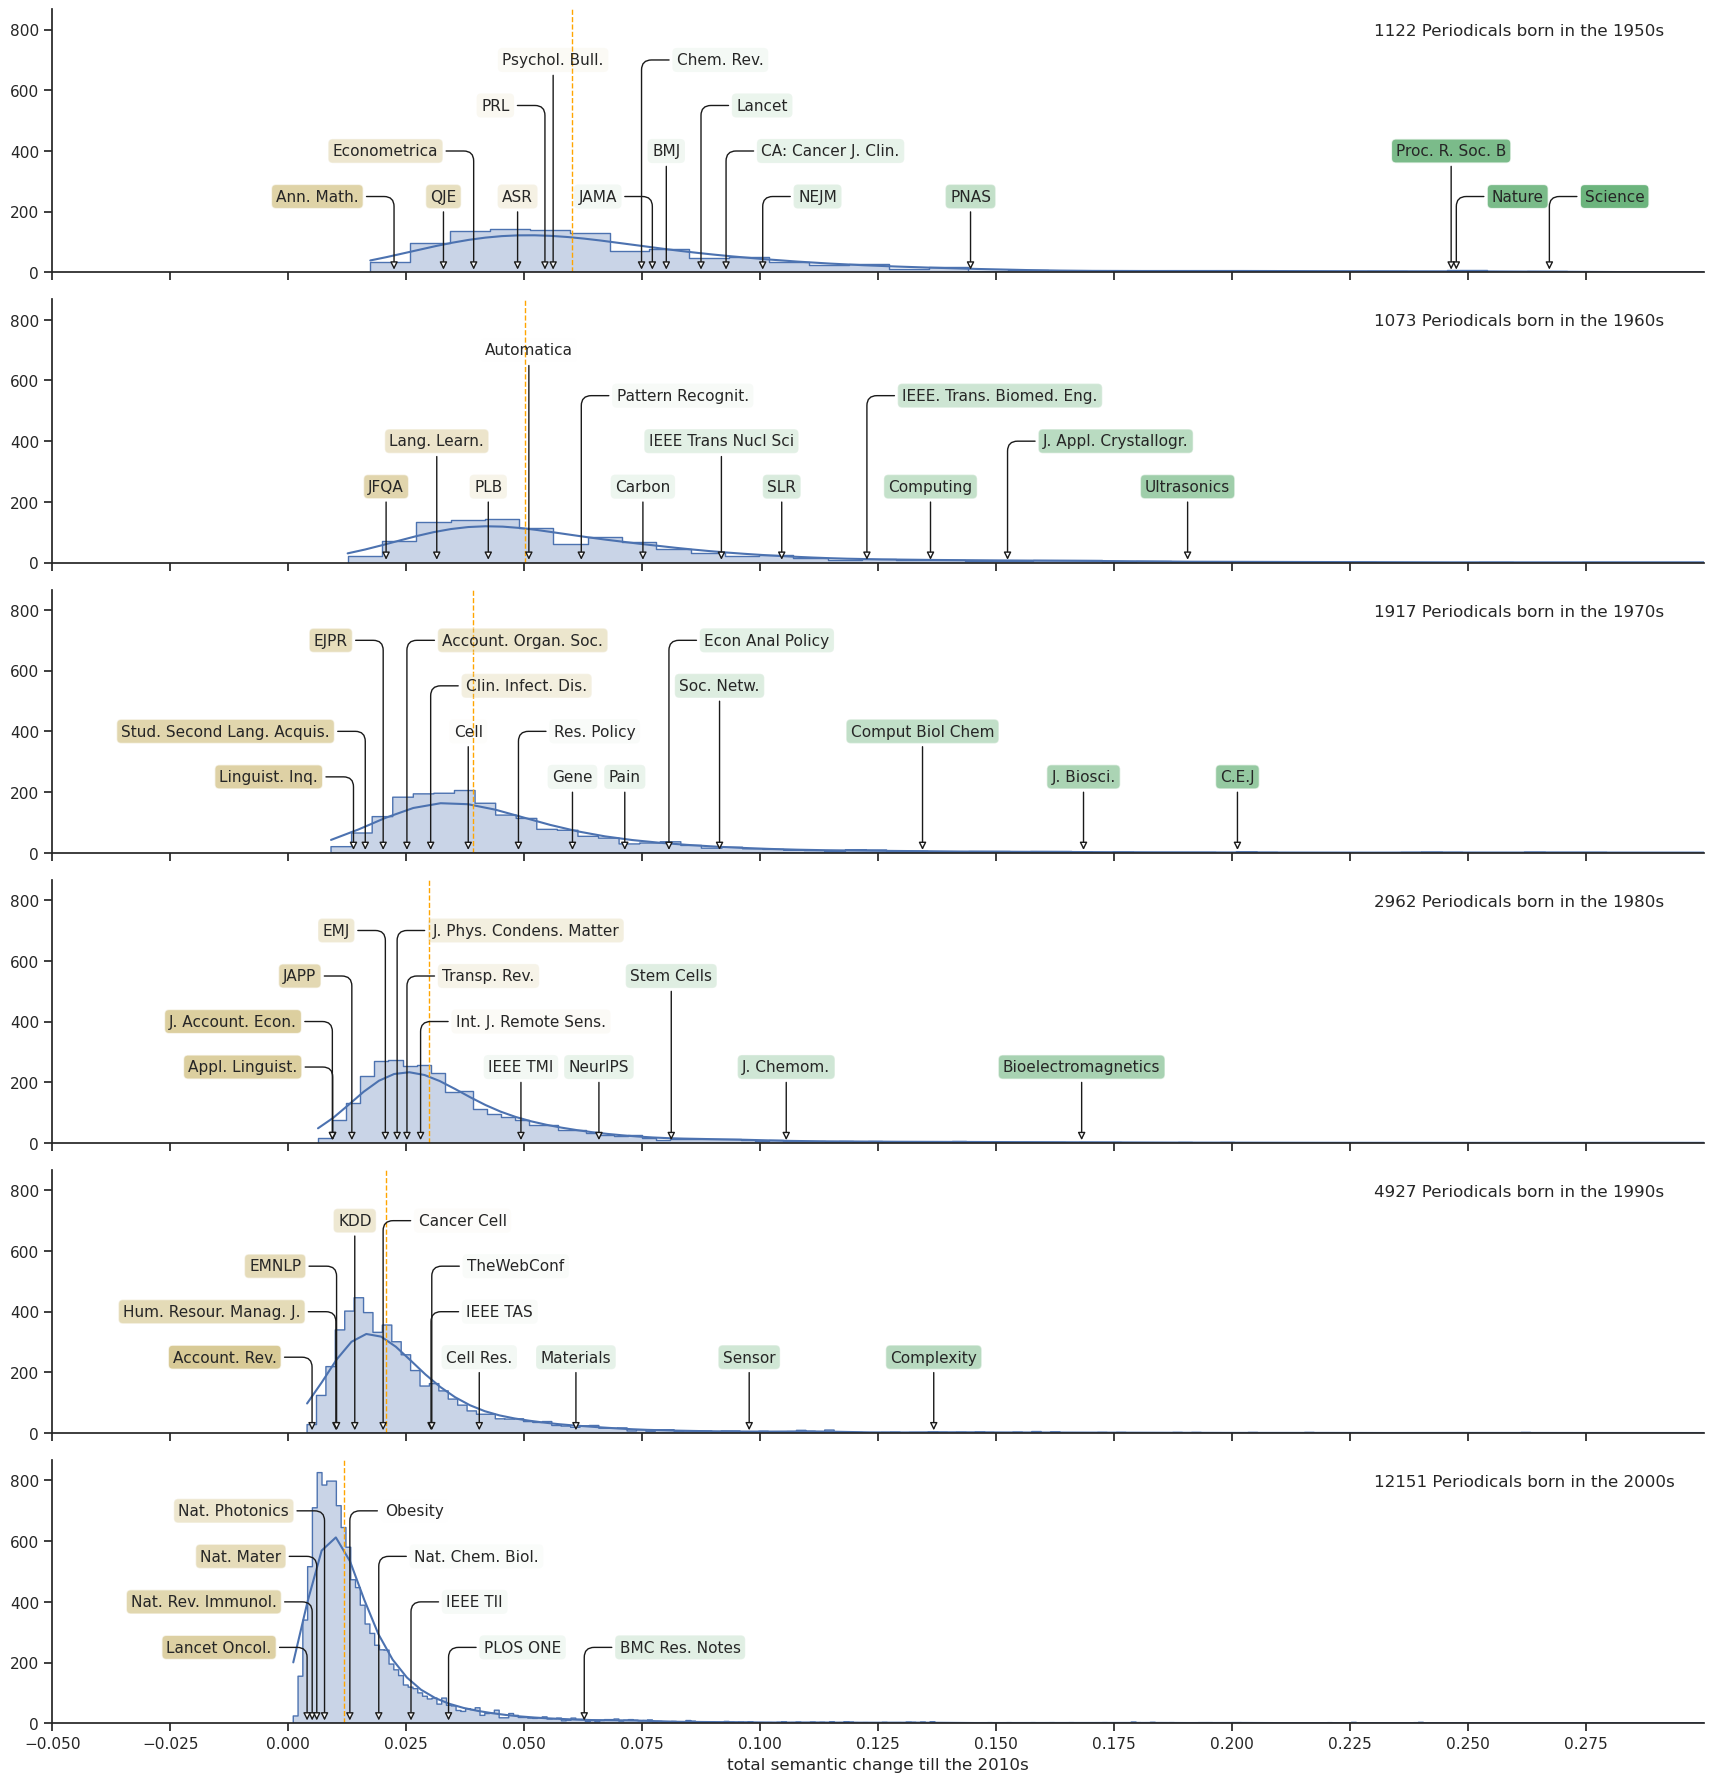

In [20]:
def annotate_n_and_decade(data, **kws):
    n = len(data)
    start_year = start_year_list[data.start_idx.unique()[0]]
    ax = plt.gca()
    ax.text(0.8, .9, f"{n} Periodicals born in the {start_year}s", transform=ax.transAxes)


def plot_median(x, **kwargs):
    ax = plt.gca()
    ax.axvline(x.median(), c='orange', ls='--', lw=1)


def annotate_periodical_name(data, opaque_value, **kwargs):
    selected_data = data[data.venue_name.isin(journal_abbr_dict.keys())]
    display()
    ax = plt.gca()
    for index, row in selected_data.iterrows():
        TSC = row.total_semantic_change_2010s
        median = data.total_semantic_change_2010s.median()
        venue_name = row.venue_name

        if TSC <= median:
            c = 'y'
            alpha = (median - TSC) / median
        if TSC > median:
            c = 'g'
            alpha = (TSC - median) / (opaque_value - median)
        # ---------------------------adjust height---------------------------
        # low
        if venue_name in [# 1950s
                          'Science', 'Psychological Bulletin', 'American Sociological Review', 'Nature', 
                          'Proceedings of the National Academy of Sciences of the United States of America', 
                          'The New England Journal of Medicine',
                          'Quarterly Journal of Economics', 'Annals of Mathematics', 'JAMA', 
                          # 1960s
                          'Carbon', 'Stanford Law Review', 'Computing', 'Ultrasonics', 'Physics Letters B', 
                          'Journal of Financial and Quantitative Analysis', 'Atmosphere', 
                          # 1970s
                          'Linguistic Inquiry', 
                          'Pain', 'Gene', 'Civil Engineering', 'Journal of Biosciences',
                          # 1980s
                          'Applied Linguistics', 'Journal of Chemometrics', 'Bioelectromagnetics',
                          'neural information processing systems', 'IEEE Transactions on Medical Imaging',
                          # 1990s
                          'The Accounting Review', 'Cell Research', 'Materials', 'Sensors', 'Complexity',
                          # 2000s
                          'PLOS ONE', 'Lancet Oncology', 'BMC Research Notes',
                         ]:
            label_y = 250
        # middle
        if venue_name in [# 1950s
                          'CA: A Cancer Journal for Clinicians', 'Econometrica', 'BMJ', 
                          'Proceedings of The Royal Society B: Biological Sciences',
                          # 1960s
                          'IEEE Transactions on Nuclear Science', 'Language Learning', 'Journal of Applied Crystallography', 
                          # 1970s
                          'Studies in Second Language Acquisition', 'Computational Biology and Chemistry', 'Cell', 'Research Policy',
                          # 1980s
                          'Journal of Accounting and Economics', 'International Journal of Remote Sensing',
                          # 1990s
                          'Human Resource Management Journal', 'IEEE Transactions on Applied Superconductivity',
                          # 2000s
                          'Nature Reviews Immunology', 'IEEE Transactions on Industrial Informatics',
                          ]:
            label_y = 400
        # high
        if venue_name in [# 1950s
                          'Physical Review Letters', 'The Lancet',
                          # 1960s
                          'Pattern Recognition', 'IEEE Transactions on Biomedical Engineering', 
                          # 1970s
                          'Clinical Infectious Diseases', 'Social Networks', 'Life sciences in space research', 
                          # 1980s
                          'Journal of Accounting and Public Policy', 'Transport Reviews', 'Stem Cells',
                          # 1990s
                          'Cancer Cell', 'the web conference', 'empirical methods in natural language processing',
                          # 2000s
                          'Nature Materials', 'Nature Chemical Biology',
                         ]:
            label_y = 550
        # ultra high
        if venue_name in [# 1950s
                          'Chemical Reviews', 'Psychological Bulletin', 
                          # 1960s
                          'Automatica',
                          # 1970s
                          'European Journal of Political Research', 'Accounting Organizations and Society', 
                          'Economic Analysis and Policy',
                          # 1980s
                          'Journal of Physics: Condensed Matter', 'European Management Journal', 
                          # 1990s
                          'Cancer Cell', 'knowledge discovery and data mining',
                          # 2000s
                          'Nature Photonics', 'Obesity',
                          ]:
            label_y = 700
            
        # ---------------------------adjust arrow direction---------------------------
        # straight arrow
        if venue_name in [# 1950s
                          'Proceedings of the National Academy of Sciences of the United States of America',
                          'American Sociological Review', 'Quarterly Journal of Economics', 'Psychological Bulletin', 'BMJ',
                          # 1960s
                          'Carbon', 'Stanford Law Review', 'Computing', 'Ultrasonics', 'Language Learning',
                          'IEEE Transactions on Nuclear Science', 'Physics Letters B', 
                          'Journal of Financial and Quantitative Analysis', 
                          'Automatica',
                          # 1970s
                          'Pain', 'Gene', 'Social Networks',
                          'Computational Biology and Chemistry', 'Civil Engineering', 'Journal of Biosciences', 'Cell',
                          # 1980s
                          'Stem Cells', 'Journal of Chemometrics', 'Bioelectromagnetics',
                          'neural information processing systems', 'IEEE Transactions on Medical Imaging',
                          # 1990s
                          'knowledge discovery and data mining', 'Complexity', 'Sensors', 'Cell Research', 'Materials',
                         # 2000s
                          'Proceedings of The Royal Society B: Biological Sciences',
                         ]:
            arrow_props = dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.", fc="w", color='k')
            label_x = TSC
            haligh = 'center'
            
        # bend arrow
        else:
            arrow_props = dict(arrowstyle="-|>", connectionstyle="angle,angleA=0,angleB=-90,rad=10", fc="w", color='k')
            # bend right
            if venue_name in [# 1950s
                              'Proceedings of the National Academy of Sciences of the United States of America',
                              'The New England Journal of Medicine', 'CA: A Cancer Journal for Clinicians', 
                              'The New England Journal of Medicine',
                              'Chemical Reviews', 'The Lancet', 'Science', 'Nature', 
                              # 1960s
                              'IEEE Transactions on Biomedical Engineering', 'Journal of Applied Crystallography', 'Pattern Recognition', 
                              # 1970s
                              'Accounting Organizations and Society', 'Clinical Infectious Diseases', 'Research Policy',
                              'Economic Analysis and Policy', 'Life sciences in space research',
                              # 1980s
                              'Transport Reviews', 'Journal of Physics: Condensed Matter', 'International Journal of Remote Sensing',
                              # 1990s
                              'the web conference', 'IEEE Transactions on Applied Superconductivity', 'Cancer Cell',
                              # 2000s
                              'Obesity', 'Nature Chemical Biology', 'IEEE Transactions on Industrial Informatics', 'PLOS ONE', 
                              'BMC Research Notes',
                             ]:
                label_x = TSC + 0.0075
                haligh = 'left'
            # bend left
            if venue_name in [# 1950s
                              'Physical Review Letters', 'Econometrica', 'Annals of Mathematics', 'JAMA', 
                              # 1960s
                              'Atmosphere', 
                              # 1970s
                              'Linguistic Inquiry', 'Studies in Second Language Acquisition', 'European Journal of Political Research', 
                              # 1980s
                              'Applied Linguistics', 'Journal of Accounting and Economics', 'European Management Journal', 
                              'Journal of Accounting and Public Policy',
                             # 1990s
                              'The Accounting Review', 'Human Resource Management Journal', 
                              'empirical methods in natural language processing',
                             # 2000s
                              'Nature Reviews Immunology', 'Nature Materials', 'Lancet Oncology', 'Nature Photonics', 
                              
            ]: 
                label_x = TSC - 0.0075
                haligh = 'right'

        bbox_props = dict(boxstyle="round", fc=c, ec="1", alpha=alpha)
        ax.annotate(journal_abbr_dict[venue_name], xy=(TSC, 0), xytext=(label_x, label_y), ha=haligh, va="center",
                    size=11, bbox = bbox_props, arrowprops = arrow_props)

plt.figure(dpi=300)
sns.set(style='white', font_scale=1)
g2 = sns.FacetGrid(local_semantic_change_df, row="start_idx", height=3, aspect=6, margin_titles=True)
g2.tick_params(axis='both', bottom='on',left='on')
g2.set(xlim=(-0.05, 0.3), xticks=np.arange(-0.05, 0.3, 0.025), yticks=np.arange(0, 1000, 200))

g2.map_dataframe(sns.histplot, x="total_semantic_change_2010s", kde=True, element='step', alpha=0.3)
g2.map(plot_median, 'total_semantic_change_2010s')
g2.map_dataframe(annotate_n_and_decade)
g2.map_dataframe(annotate_periodical_name, data=local_semantic_change_df, opaque_value=0.3)

for ax in g2.axes.flatten():
    ax.set_ylabel('')
g2.set_titles(row_template='')
g2.set_xlabels('total semantic change till the 2010s')

plt.show()

In [21]:
g2.savefig('total_local_semantic_change.pdf', 
          dpi = 300, 
          facecolor='white', 
          transparent=False, 
          bbox_inches='tight')

# Aggregate total local semantic change into discipline level 

In [22]:
discipline_abbr_dict = {'Business, Management and Accounting':	'Bus., MGMT & ACCT',
             'Decision Sciences': 'Decis.',
             'Arts and Humanities': 'Arts & HUMN',
             'Nursing': 'Nursing',
             'Pharmacology, Toxicology and Pharmaceutics': 'Pharm.',
             'Health Professions': 'Health Pro',
             'Computer Science': 'CS',
             'Medicine': 'Med.',
             'Environmental Science': 'Env.',
             'Dentistry': 'Dentistry',
             'Social Sciences': 'Soc.',
             'Engineering': 'Eng.',
             'Veterinary': 'Vet.',
             'Economics, Econometrics and Finance': 'Econ.',
             'Biochemistry, Genetics and Molecular Biology': 'Biochem.',
             'Energy': 'NRG',
             'Neuroscience': 'Neuro.',
             'Immunology and Microbiology': 'Immunol. & Microbiol.',
             'Agricultural and Biological Sciences': 'AG & Bio.',
             'Multidisciplinary': 'Multidiscip.',
             'Materials Science': 'Mat.',
             'Mathematics': 'Math',
             'Earth and Planetary Sciences': 'Earth',
             'Chemical Engineering': 'Chem. Eng.',
             'Psychology': 'Psy.',
             'Chemistry': 'Chem.',
             'Physics and Astronomy': 'Phy. & Astron.',
}

In [23]:
# check all multidisciplinary periodicals
local_semantic_change_df.sort_values(by='total_semantic_change_2010s', ascending=False)[local_semantic_change_df['scopus_label']=='Multidisciplinary'][['total_semantic_change_2010s', 'venue_name', 'scopus_label']]

/tmp/ipykernel_366268/366324461.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  local_semantic_change_df.sort_values(by='total_semantic_change_2010s', ascending=False)[local_semantic_change_df['scopus_label']=='Multidisciplinary'][['total_semantic_change_2010s', 'venue_name', 'scopus_label']]


,total_semantic_change_2010s,venue_name,scopus_label
1539,0.739106,Science Progress,Multidisciplinary
1249,0.583474,American Scientist,Multidisciplinary
342,0.390925,Scientific American,Multidisciplinary
5244,0.381349,New Scientist,Multidisciplinary
979,0.267192,Science,Multidisciplinary
85,0.247474,Nature,Multidisciplinary
13443,0.236729,Arabian Journal for Science and Engineering,Multidisciplinary
13143,0.217291,Doklady Akademii Nauk,Multidisciplinary
14115,0.204050,Wuhan University Journal of Natural Sciences,Multidisciplinary
297,0.202890,Current Science,Multidisciplinary


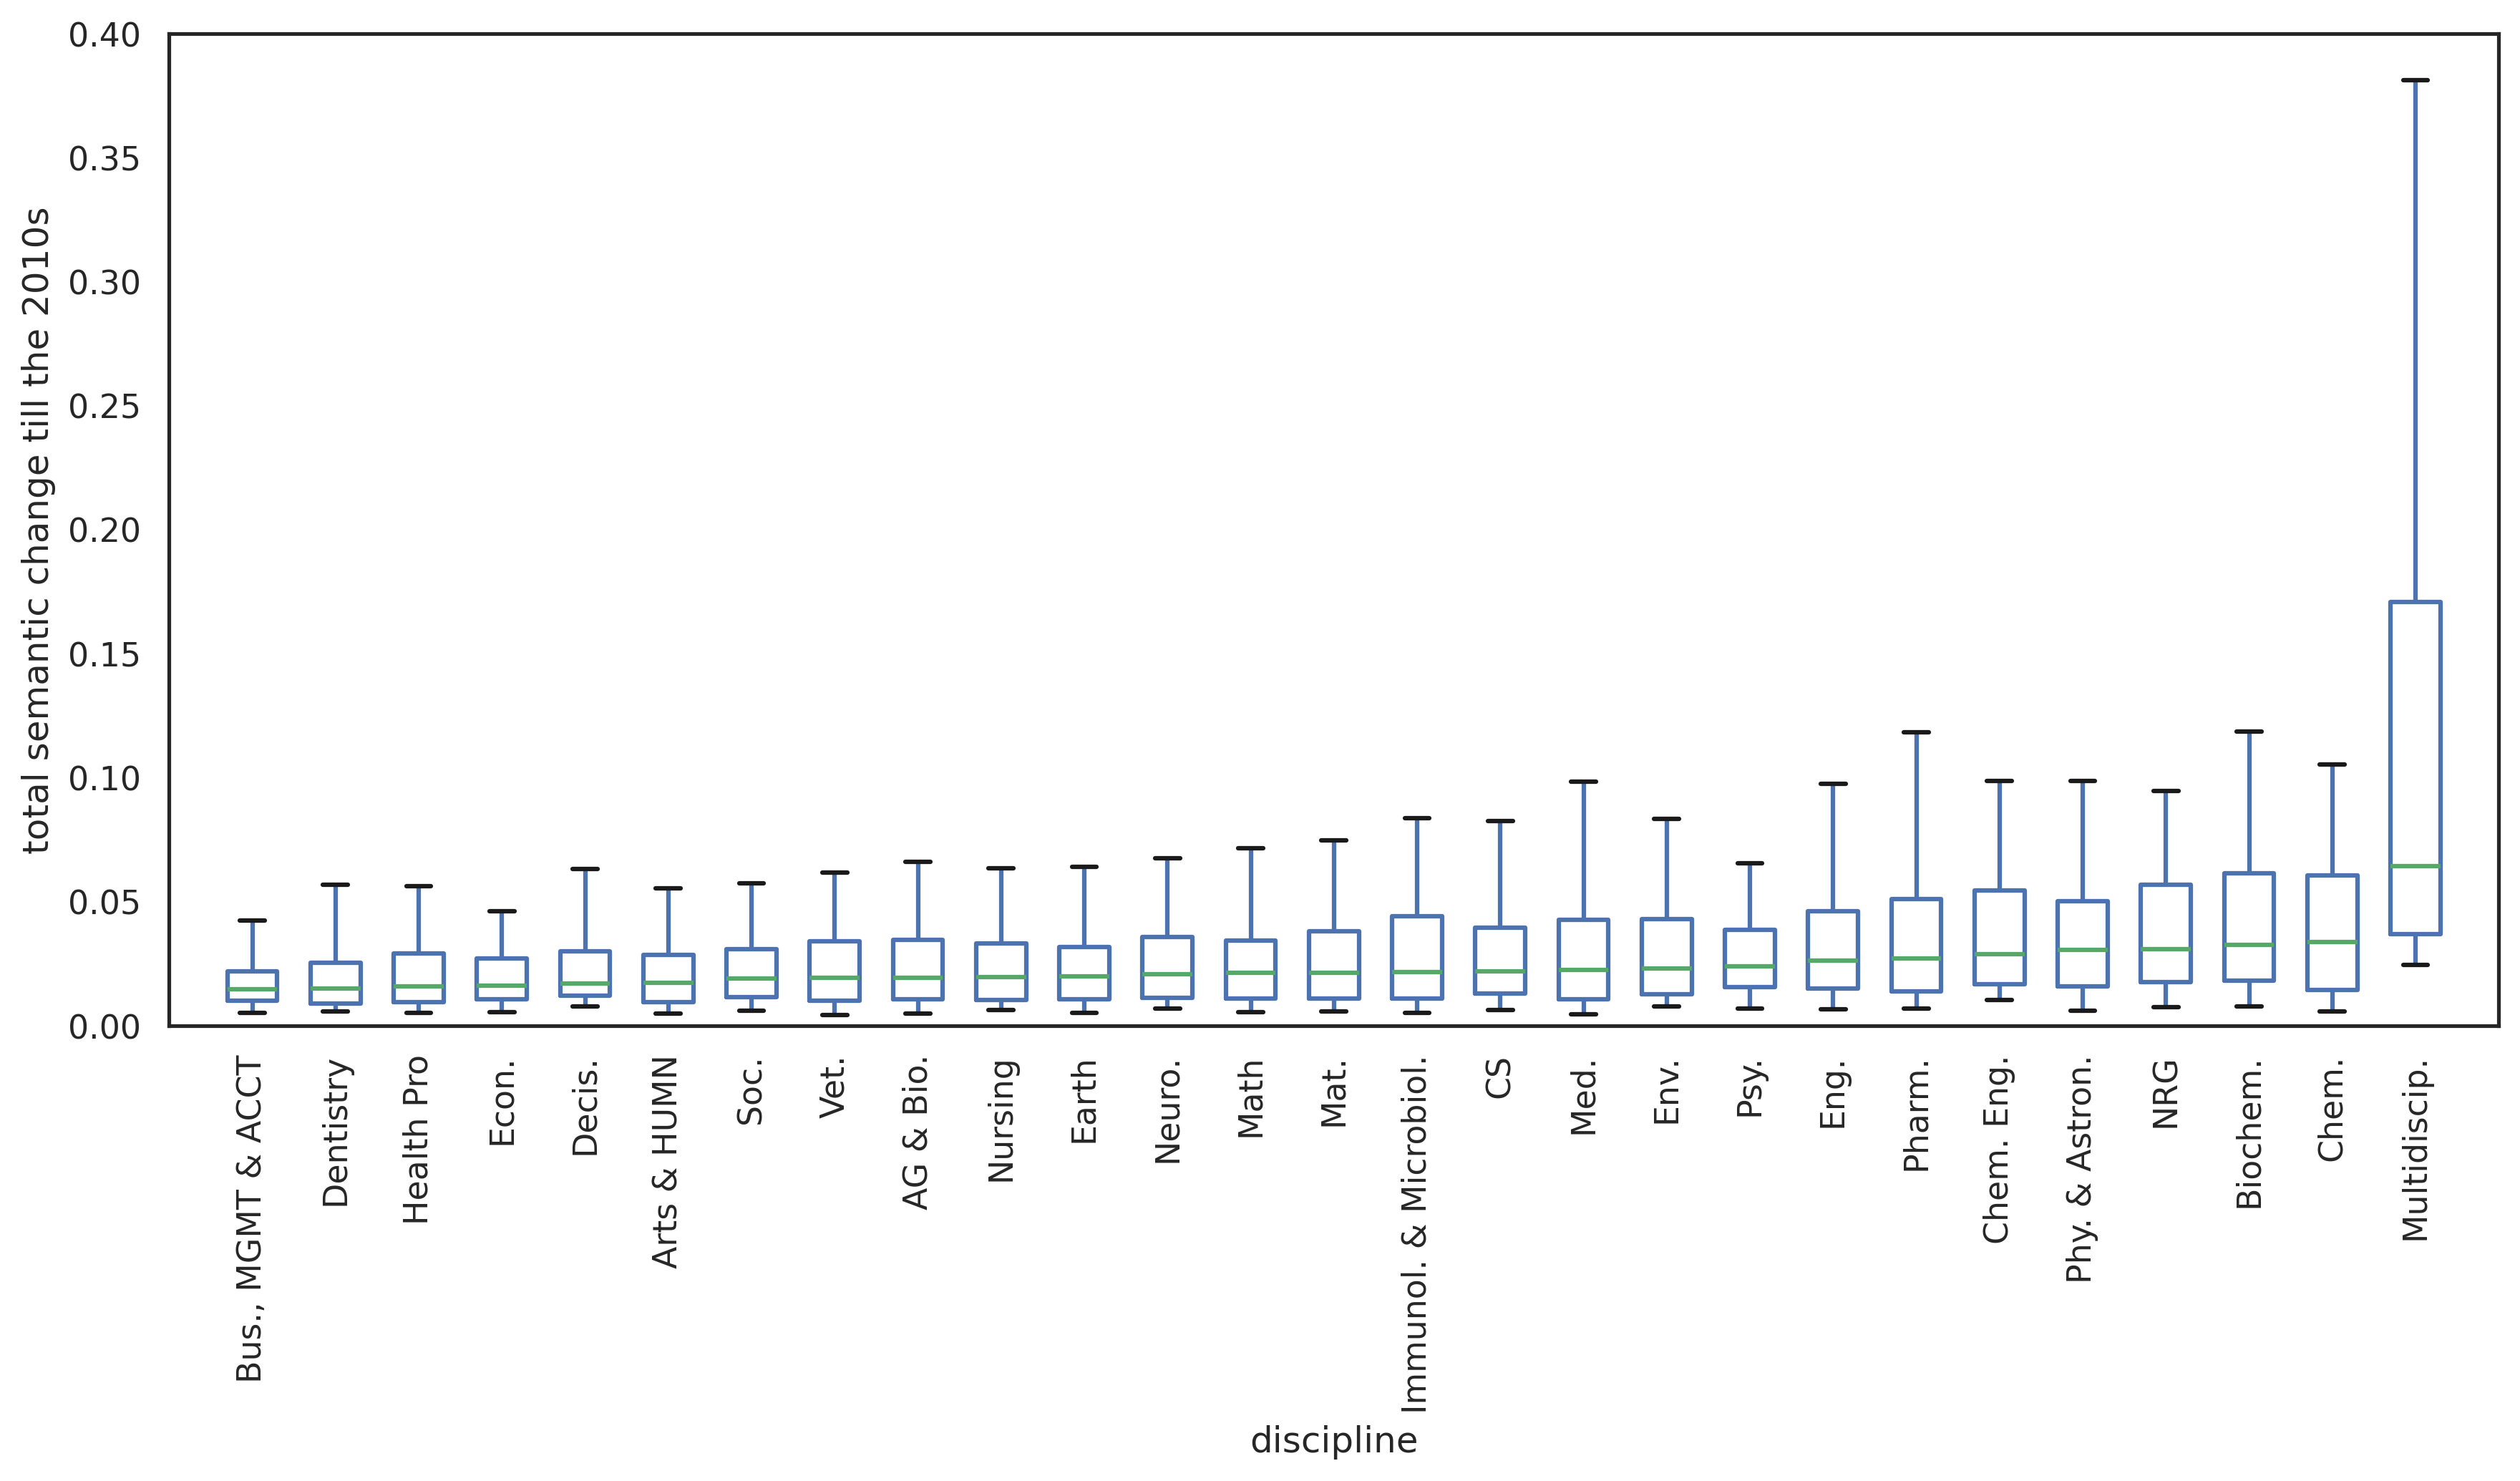

In [24]:
local_semantic_change_df_rename = local_semantic_change_df.copy()
local_semantic_change_df_rename.scopus_label = local_semantic_change_df_rename.scopus_label.replace(discipline_abbr_dict)
col_name = 'total_semantic_change_2010s'

plt.figure(figsize=(14,6), dpi=300)
plt.xticks(rotation=90)
g3 = sns.boxplot(x="scopus_label", y="total_semantic_change_2010s", data=local_semantic_change_df_rename, 
                 order=local_semantic_change_df_rename.groupby('scopus_label').agg({col_name:'median'}).sort_values(by=col_name).index.to_list(),
                 whis=(5,95), fliersize=0, fill=False, gap=0.25,
                 medianprops={'color': 'g'},
                 capprops={'color': 'k'},
                )
g3.set(xlabel='discipline',
       ylabel='total semantic change till the 2010s',
       ylim=(0.0, 0.4),
       xlim=(-1, len(discipline_abbr_dict))
      )
plt.show()

In [25]:
g3.get_figure().savefig('total_local_semantic_change_by_discipline.pdf', 
          dpi = 300, 
          facecolor='white', 
          transparent=False, 
          bbox_inches='tight')